<a href="https://colab.research.google.com/github/lisaong/mldds-courseware/blob/master/04_SpeechTimeSeries/LSTM_time_series_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM time series models (data.gov)

Reference:
https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

Dataset (you can try others as well):
https://data.gov.sg/dataset/gross-domestic-product-in-chained-2015-dollars-year-on-year-growth-rate-quarterly

Download the dataset from data.gov to the same location as this notebook.

If using Colab: Upload it to the Files tab in Colab

In [1]:
# This command only works in Colab
# specify tensorflow 2.0 before import tensorflow
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Similar to StandardScaler, but scales between -1 and 1 for RNN training
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Stationarity test
# conda install statsmodels
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint

sns.set_style('whitegrid')
%matplotlib inline

tf.__version__

'2.1.0-rc1'

In [4]:
# From Colab, easy way get this path, "right click -> Copy Path"
df = pd.read_csv('./gross-domestic-product-in-chained-2015-dollars-year-on-year-growth-rate-quarterly.csv', parse_dates=True, index_col=0)
df.head()

,level_1,value
quarter,,
1976-01-01,GDP In Chained (2015) Dollars,8.2
1976-04-01,GDP In Chained (2015) Dollars,7.4
1976-07-01,GDP In Chained (2015) Dollars,7.2
1976-10-01,GDP In Chained (2015) Dollars,7.0
1977-01-01,GDP In Chained (2015) Dollars,6.2


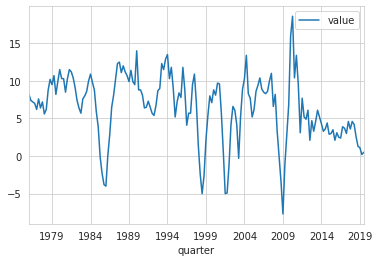

In [5]:
# Plot the series
df.plot()
plt.show()

## Data Preparation

- Check for stationarity
- Performing windowing to split a sequence into columns.


In [0]:
# Check for stationairty. pvalue > 0.05 means the series is NOT stationary (has unit root)

adfuller(df['value'])

# How to interpret:
#
# (-2.8256920599042608,
#  0.05469652181207146,
# 11,
# 163,
# {'1%': -3.471118535474365,
#  '10%': -2.576313761526591,
#  '5%': -2.8794405060097024},
# 696.8540385364829)
#
# first score is the raw ADF statistic. You can compare against the 5% value of (-2.879)
# second score is the p-value (if >0.05, then it is NOT stationary)

(-2.8256920599042608,
 0.05469652181207146,
 11,
 163,
 {'1%': -3.471118535474365,
  '10%': -2.576313761526591,
  '5%': -2.8794405060097024},
 696.8540385364829)

 0.05469652181207146 > 0.05

(Non-stationary)

In [7]:
# take the first order difference to make this a stationary series

df['diff'] = df['value'].diff() # how to convert to stationary
df.dropna(inplace=True) # first row will always be NaN because it has
                        # no prev value to compute against
df.head()

,level_1,value,diff
quarter,,,
1976-07-01,GDP In Chained (2015) Dollars,7.2,-0.2
1976-10-01,GDP In Chained (2015) Dollars,7.0,-0.2
1977-01-01,GDP In Chained (2015) Dollars,6.2,-0.8
1977-04-01,GDP In Chained (2015) Dollars,7.6,1.4
1977-07-01,GDP In Chained (2015) Dollars,6.4,-1.2


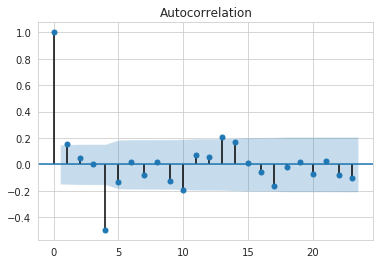

In [8]:
# How to determine a "good" window size
# use plot_acf

from statsmodels.graphics.tsaplots import plot_acf

# x-axis is the number of lags (window size)
plot_acf(df['diff'])
plt.show()

# based on the plot, lag=4 has correlation above the 95% percentile
# lag=0 always gives correlation of 1

In [9]:
# Windowing to split a sequence into columns.
window_size = 4+1 # add 1 for the target column

shifted = [df['diff'].shift(-i) for i in range(window_size)]
df_windowed = pd.concat(shifted, axis=1).dropna()
df_windowed.columns = [f'y[t+{i}]' for i in range(window_size)]
df_windowed.head()

,y[t+0],y[t+1],y[t+2],y[t+3],y[t+4]
quarter,,,,,
1976-07-01,-0.2,-0.2,-0.8,1.4,-1.2
1976-10-01,-0.2,-0.8,1.4,-1.2,0.8
1977-01-01,-0.8,1.4,-1.2,0.8,-1.6
1977-04-01,1.4,-1.2,0.8,-1.6,0.6
1977-07-01,-1.2,0.8,-1.6,0.6,2.6


## Select X and y

- X: all columns except last column
- y: last column
- Reshape to train for RNN
- Train test split without shuffling (to preserve ordering)
- Min-max Scaling to -1, 1 range

In [0]:
# .values returns the numpy array for easier manipulation

# X: all columns except last column
X = df_windowed.iloc[:, :-1].values

# y: last column
y = df_windowed.iloc[:, -1].values

In [11]:
X.shape, y.shape

((169, 4), (169,))

In [0]:
# Reshape to train for RNN

n_steps = window_size-1
n_features = 1

# reshape from [samples, timesteps] into [samples, timesteps, features]
X_rnn = X.reshape(X.shape[0], X.shape[1], n_features)

In [13]:
X_rnn.shape

(169, 4, 1)

In [0]:
# train test split without shuffling (to preserve ordering)
X_train, X_test, y_train, y_test = train_test_split(X_rnn, y, test_size=0.2, shuffle=False)

In [15]:
X_train.shape, X_test.shape

((135, 4, 1), (34, 4, 1))

In [16]:
# look at the X_train, you will see a list of column vectors, 
# where each column vector is of shape (4, 1)
X_train

array([[[-0.2],
        [-0.2],
        [-0.8],
        [ 1.4]],

       [[-0.2],
        [-0.8],
        [ 1.4],
        [-1.2]],

       [[-0.8],
        [ 1.4],
        [-1.2],
        [ 0.8]],

       [[ 1.4],
        [-1.2],
        [ 0.8],
        [-1.6]],

       [[-1.2],
        [ 0.8],
        [-1.6],
        [ 0.6]],

       [[ 0.8],
        [-1.6],
        [ 0.6],
        [ 2.6]],

       [[-1.6],
        [ 0.6],
        [ 2.6],
        [ 1.4]],

       [[ 0.6],
        [ 2.6],
        [ 1.4],
        [-0.7]],

       [[ 2.6],
        [ 1.4],
        [-0.7],
        [ 1.2]],

       [[ 1.4],
        [-0.7],
        [ 1.2],
        [-2.5]],

       [[-0.7],
        [ 1.2],
        [-2.5],
        [ 1.7]],

       [[ 1.2],
        [-2.5],
        [ 1.7],
        [ 1.6]],

       [[-2.5],
        [ 1.7],
        [ 1.6],
        [-1.2]],

       [[ 1.7],
        [ 1.6],
        [-1.2],
        [ 0. ]],

       [[ 1.6],
        [-1.2],
        [ 0. ],
        [-1.8]],

       [[-

In [0]:
# Scaling
# In general, scaling will improve performance because the activation
# is between -1 and 1

# setup the scalers to use -1, 1 range
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

# X is 3 dimensions e.g. (135, 4, 1)
# since scaling only works for dimensions <= 2 (and X_train has 3 dimensions),
# X_train.squeeze() will convert it to 2 dimensions
# np.expand_dims() will add back the 3rd dimension
X_train_sc = X_scaler.fit_transform(X_train.squeeze())
X_train_sc = np.expand_dims(X_train_sc, axis=2)
X_test_sc = X_scaler.transform(X_test.squeeze())
X_test_sc = np.expand_dims(X_test_sc, axis=2)

# y is 1 dimension e.g. (135,)
# .reshape(-1, 1) will add a new dimension of size 1 while preserving
y_train_sc = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_sc = y_scaler.transform(y_test.reshape(-1, 1))

## Vanilla LSTM

Vanilla LSTM is an LSTM model that has a single hidden layer of LSTM units, followed by a dense layer used to make a prediction.

In [33]:
# define model

model = Sequential()
model.add(LSTM(100, input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile the model, use rmsprop (a common optimiser for RNNs, and use mse as loss because we are performing
# regression)
model.compile(loss='mse', optimizer='rmsprop')

In [0]:
mc = ModelCheckpoint('./vanilla_lstm.h5', save_best_only=True)

In [38]:
history = model.fit(X_train_sc, y_train_sc, epochs=200, validation_data=(X_test_sc, y_test_sc), callbacks=[mc])

Train on 135 samples, validate on 34 samples
Epoch 1/200
135/135 [==============================] - 0s 484us/sample - loss: 0.0721 - val_loss: 0.0315
Epoch 2/200
135/135 [==============================] - 0s 338us/sample - loss: 0.0726 - val_loss: 0.0322
Epoch 3/200
135/135 [==============================] - 0s 397us/sample - loss: 0.0717 - val_loss: 0.0310
Epoch 4/200
135/135 [==============================] - 0s 397us/sample - loss: 0.0716 - val_loss: 0.0298
Epoch 5/200
135/135 [==============================] - 0s 362us/sample - loss: 0.0703 - val_loss: 0.0303
Epoch 6/200
135/135 [==============================] - 0s 323us/sample - loss: 0.0718 - val_loss: 0.0319
Epoch 7/200
135/135 [==============================] - 0s 295us/sample - loss: 0.0712 - val_loss: 0.0312
Epoch 8/200
135/135 [==============================] - 0s 333us/sample - loss: 0.0711 - val_loss: 0.0302
Epoch 9/200
135/135 [==============================] - 0s 283us/sample - loss: 0.0710 - val_loss: 0.0310
Epoch 10/2

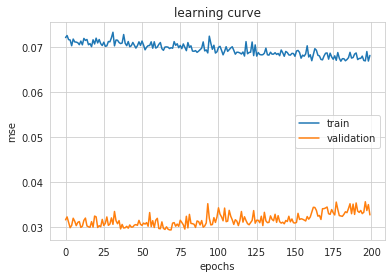

In [39]:
# plot the learning curve
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='validation')
ax.set_title('learning curve')
ax.set_xlabel('epochs')
ax.set_ylabel('mse')
ax.legend()
plt.show()

### Predict

In [40]:
best_model = load_model('./vanilla_lstm.h5')
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [49]:
# last 5 values of the test set
test, testy = X_test_sc[-5:], y_test_sc[-5:]
test, testy

(array([[[-0.02702703],
         [-0.37837838],
         [ 0.05747126],
         [-0.10344828]],
 
        [[-0.37837838],
         [-0.10810811],
         [-0.10344828],
         [-0.24137931]],
 
        [[-0.10810811],
         [-0.2972973 ],
         [-0.24137931],
         [-0.20689655]],
 
        [[-0.2972973 ],
         [-0.45945946],
         [-0.20689655],
         [-0.08045977]],
 
        [[-0.45945946],
         [-0.41891892],
         [-0.08045977],
         [-0.16091954]]]), array([[-0.24137931],
        [-0.20689655],
        [-0.08045977],
        [-0.16091954],
        [-0.02298851]]))

In [50]:
pred = best_model.predict(test)

mean_squared_error(testy, pred), r2_score(testy, pred)

(0.0075174121460549305, -0.16026289831749096)

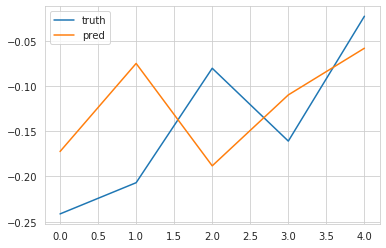

In [51]:
fig, ax = plt.subplots()
ax.plot(testy, label='truth')
ax.plot(pred, label='pred')
ax.legend()
plt.show()

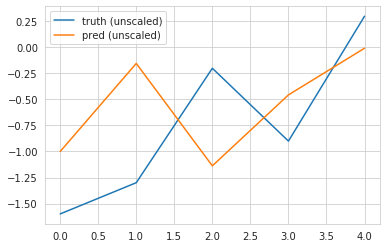

In [52]:
# Plot unscaled predictions vs. actual

pred_unscaled = y_scaler.inverse_transform(pred)

fig, ax = plt.subplots()
ax.plot(y_test[-5:], label='truth (unscaled)')
ax.plot(pred_unscaled, label='pred (unscaled)')
ax.legend()
plt.show()

## Stacked LSTM

Multiple hidden LSTM layers can be stacked one on top of another in what is referred to as a Stacked LSTM model.

An LSTM layer requires a three-dimensional input and LSTMs by default will produce a two-dimensional output as an interpretation from the end of the sequence.

We can address this by having the LSTM output a value for each time step in the input data by setting the return_sequences=True argument on the layer. This allows us to have 3D output from hidden LSTM layer as input to the next.

In [53]:
# define model
model1 = Sequential()

model1.add(LSTM(100, return_sequences=True, input_shape=(n_steps, n_features)))
model1.add(LSTM(100))
model1.add(Dense(1))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 100)            40800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [0]:
# compile the model
model1.compile(loss='mse', optimizer='rmsprop')

In [0]:
mc1 = ModelCheckpoint('./stacked_lstm.h5', save_best_only=True)

In [58]:
history = model1.fit(X_train_sc, y_train_sc, epochs=200, validation_data=(X_test_sc, y_test_sc), callbacks=[mc1])

Train on 135 samples, validate on 34 samples
Epoch 1/200
135/135 [==============================] - 1s 4ms/sample - loss: 0.1022 - val_loss: 0.0461
Epoch 2/200
135/135 [==============================] - 0s 498us/sample - loss: 0.0981 - val_loss: 0.0475
Epoch 3/200
135/135 [==============================] - 0s 448us/sample - loss: 0.0959 - val_loss: 0.0523
Epoch 4/200
135/135 [==============================] - 0s 557us/sample - loss: 0.0947 - val_loss: 0.0416
Epoch 5/200
135/135 [==============================] - 0s 443us/sample - loss: 0.0907 - val_loss: 0.0429
Epoch 6/200
135/135 [==============================] - 0s 635us/sample - loss: 0.0884 - val_loss: 0.0379
Epoch 7/200
135/135 [==============================] - 0s 472us/sample - loss: 0.0870 - val_loss: 0.0473
Epoch 8/200
135/135 [==============================] - 0s 575us/sample - loss: 0.0860 - val_loss: 0.0350
Epoch 9/200
135/135 [==============================] - 0s 617us/sample - loss: 0.0860 - val_loss: 0.0349
Epoch 10/200

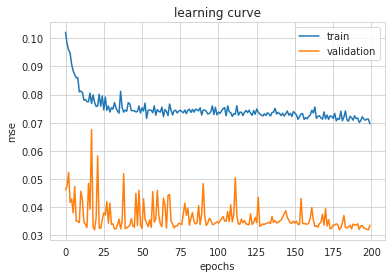

In [59]:
# plot the learning curve
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='validation')
ax.set_title('learning curve')
ax.set_xlabel('epochs')
ax.set_ylabel('mse')
ax.legend()
plt.show()

### Predict

In [60]:
best_model = load_model('./stacked_lstm.h5')
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 100)            40800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [61]:
pred_stacked = best_model.predict(test) # since this LSTM is not stateful, no need to fast-forward

mean_squared_error(testy, pred_stacked), r2_score(testy, pred_stacked)

(0.00769729497785016, -0.1880266249459186)

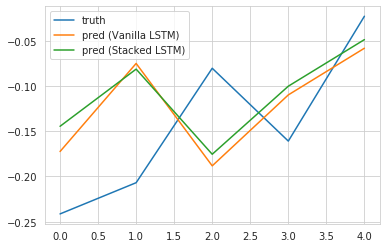

In [62]:
fig, ax = plt.subplots()
ax.plot(testy, label='truth')
ax.plot(pred, label='pred (Vanilla LSTM)')
ax.plot(pred_stacked, label='pred (Stacked LSTM)')
ax.legend()
plt.show()

### Observations

Both Vanilla and Stack LSTM predict more "averaged" results. The averaging seems to get worse with Stacked LSTM (we are passing through deeper layers). 

Possible experiments:
- Reduce the timesteps so that we are only looking at shorter term fluctuations (last 1-2 months).
- Try a wider LSTM (more units) rather than a deeper one to learn the patterns. There doesn't seem to be much pattern...
- Try a Conv LSTM. Although Conv probably will result in more temporal averaging as well.
- Try ARIMA to see if statistical method can perform better.